In [17]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
sys.path.append('../')
from plancklens import utils
from tqdm import tqdm
from getdist import plots, MCSamples

In [2]:
%load_ext autoreload
%autoreload 2
from dance.filtering import WienerFilter
from dance.qe import Reconstruct
from dance.delens import Delens
from dance.utils import bin_cmb_spectrum

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes


In [3]:
import emcee

In [4]:
def theory(acb,L):
      return np.exp(acb) * 2 * np.pi / ( L**2 + L + 1e-30)

def chi_sq(acb):
        theory_cl = theory(acb,bb)
        delta = data.mean(axis=0) - theory_cl
        return np.sum((delta)**2 / data.std(axis=0)**2)

def log_likelihood(theta):
    return -0.5 * chi_sq(theta)


def log_prior(theta):
    if -14 < theta < -12:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


def get_pos_nwalkers_ndim():
    pos = [-13.8] + 1e-1 * np.random.randn(32, 1)
    nwalkers, ndim = pos.shape
    return pos, nwalkers, ndim

def get_samp():
    pos, nwalkers, ndim = get_pos_nwalkers_ndim()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=24,)
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.get_chain(discard=100, thin=15, flat=True)
    return samples


In [5]:
basedir = '/mnt/sdceph/users/alonappan/DANCE'

In [6]:
recon_aniso = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p")

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected


CMB : INFO - Loading CMB power spectra from file
/mnt/home/alonappan/anaconda3/cstm_pkgs/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


In [7]:
delens = Delens(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="p_p",lmin_delens=50,lmax_delens=4096)
recon_delens = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p",delens=delens)

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


Delens Filtering


In [8]:
ap_bd = []
for i in tqdm(range(100)):
    oalm = recon_aniso.get_qlm(i)
    talm = recon_aniso.get_qlm_th(i)
    cl = hp.alm2cl(oalm,talm)
    ap_bd.append(cl)
ap_bd = np.array(ap_bd)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:45<00:00,  4.65s/it]


In [9]:
ap_ad = []
for i in tqdm(range(100)):
    oalm = recon_delens.get_qlm(i)
    talm = recon_delens.get_qlm_th(i)
    cl = hp.alm2cl(oalm,talm)
    ap_ad.append(cl)
ap_ad = np.array(ap_ad)

  8%|▊         | 8/100 [00:36<07:00,  4.57s/it]

100%|██████████| 100/100 [07:41<00:00,  4.62s/it]


In [10]:
ap_bd_bin = []
for i in tqdm(range(100)):
    bd_bin, bcl = bin_cmb_spectrum(ap_bd[i],2)
    ap_bd_bin.append(bcl)
ap_bd_bin = np.array(ap_bd_bin)

100%|██████████| 100/100 [00:01<00:00, 52.28it/s]


In [11]:
ap_ad_bin = []
for i in tqdm(range(100)):
    ad_bin, bcl = bin_cmb_spectrum(ap_ad[i],2)
    ap_ad_bin.append(bcl)
ap_ad_bin = np.array(ap_ad_bin)

100%|██████████| 100/100 [00:01<00:00, 52.23it/s]


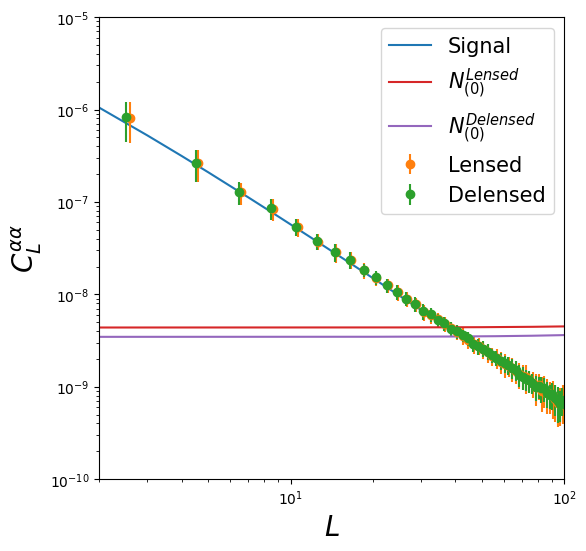

In [162]:
plt.figure(figsize=(6,6))
plt.loglog(recon_aniso.cmb.cl_aa(),label='Signal')
plt.errorbar(bd_bin+0.1,ap_bd_bin.mean(axis=0),ap_bd_bin.std(axis=0),fmt='o', label='Lensed')
plt.errorbar(ad_bin,ap_ad_bin.mean(axis=0),ap_ad_bin.std(axis=0),fmt='o', label='Delensed')
plt.loglog(recon_aniso.get_n0(0),label='$N_{(0)}^{Lensed}$')
plt.loglog(recon_delens.get_n0(0),label='$N_{(0)}^{Delensed}$')
plt.ylim(1e-10,1e-5)
plt.xlim(2,100)
plt.xlabel('$L$', fontsize=20)
plt.ylabel(r'$C_L^{\alpha \alpha}$', fontsize=20)
plt.legend(fontsize=15)
plt.savefig('claa.pdf',bbox_inches='tight',dpi=300)

In [12]:
data = ap_bd_bin.copy()
bb = bd_bin.copy()
sel = np.where((bb>2) & (bb<100))[0]
data = data[:,sel]
bb = bb[sel]
bdsamp = get_samp()

100%|██████████| 5000/5000 [00:11<00:00, 453.19it/s]


In [13]:
data = ap_ad_bin.copy()
bb = ad_bin.copy()
sel = np.where((bb>2) & (bb<100))[0]
data = data[:,sel]
bb = bb[sel]
adsamp = get_samp()

100%|██████████| 5000/5000 [00:10<00:00, 455.49it/s]


In [172]:
np.log(1e-6)

-13.815510557964274

In [14]:
correction = np.mean(adsamp) - (-13.815)
mbdsamp = bdsamp - correction

In [15]:
correction = np.mean(adsamp) - (-13.815)
madsamp = adsamp - correction

In [154]:
sampl = np.exp(adsamp)
sampl.mean(), sampl.std()

(1.0493114240610783e-06, 3.252298799820407e-08)

In [155]:
1 - 3.25/3.6

0.09722222222222221

In [18]:
from getdist import MCSamples, plots

In [21]:
names = ['acb']
labels =  ["\mathrm{ln}\;A_{CB}"]
bdSamp =  MCSamples(samples=mbdsamp, names = names, labels = labels, label='Lensed')
adSamp =  MCSamples(samples=madsamp, names = names, labels = labels, label='Delensed')

Removed no burn in
Removed no burn in


In [22]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([bdSamp,adSamp], filled=True)
plt.axvline(np.log(1e-6), c='k', ls='--')
plt.savefig('triangle.pdf',bbox_inches='tight',dpi=300)